In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, Layer
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')

In [3]:
df = df.sample(frac=1., random_state=42)
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
437478,1367.286865,0.514140,36.874817,-0.567162,-0.051784,26,32,-41.350748,-42.145892,0.289053,0
633446,1349.734497,0.461035,15.258850,-1.076562,-1.548793,45,63,-22.185350,-10.916061,0.249620,0
93057,2834.843506,3.014004,61.552490,-1.235404,1.805601,16,31,-58.638833,-54.183687,0.215897,0
582194,1380.331421,0.739724,52.043762,0.897393,0.134441,25,62,-42.472107,-12.314901,0.138052,0
649851,1528.705688,1.784996,92.635620,0.002620,1.822954,47,40,-21.761047,-36.131667,0.401371,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,1285.024292,0.913437,8.821899,-0.431818,0.493761,27,35,-39.554488,-38.044520,0.359813,0
365838,1359.271973,0.337475,92.623596,0.944897,0.632759,41,55,-26.275523,-19.041290,0.593621,0
131932,2054.116943,2.140792,145.848389,-1.060299,1.120960,65,38,-7.119301,-43.129277,0.308462,0
671155,1248.218506,1.125891,124.323944,0.073235,1.242163,18,32,-48.180650,-40.531574,0.394253,0


In [4]:
features = df.iloc[:, :-2]
labels = df.labels

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [6]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_train_control = y_train[x_train_control.index]

In [7]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.iloc[:, :7])
x_test = scaler.fit_transform(x_test.iloc[:, :7])

x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

## Encoder

In [8]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
x_input = Input(shape = (7,), name = 'Input')
enc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(x_input)
z_mean = Dense(7, name = 'z_mean')(enc_1)
z_var = Dense(7, name = 'z_var')(enc_1)
z = Sampling()([z_mean, z_var])
encoder = Model(x_input, [z_mean, z_var, z], name = 'Encoder')
    
decoder_input = Input(shape = (7, ), name = 'Decoder_input')
denc_1 = Dense(16, activation='relu', name = 'Dense_encoder_1')(decoder_input)
output = Dense(7, activation = 'sigmoid', name = 'Output')(denc_1)
decoder = Model(decoder_input, output, name = 'Decoder')

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
 
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [41]:
#history_val = vae.fit(x_val, epochs = 5, batch_size = 128)
history = vae.fit(x_train_control, epochs = 5, batch_size = 128)

Epoch 1/5
6364/6364 [==============================] - 6s 886us/step - loss: 0.0295 - reconstruction_loss: 0.0292 - kl_loss: 3.3800e-04
Epoch 2/5
6364/6364 [==============================] - 5s 862us/step - loss: 0.0284 - reconstruction_loss: 0.0283 - kl_loss: 9.5799e-07
Epoch 3/5
6364/6364 [==============================] - 6s 867us/step - loss: 0.0283 - reconstruction_loss: 0.0283 - kl_loss: 6.8976e-07
Epoch 4/5
6364/6364 [==============================] - 6s 866us/step - loss: 0.0283 - reconstruction_loss: 0.0283 - kl_loss: 5.2730e-07
Epoch 5/5
6364/6364 [==============================] - 5s 860us/step - loss: 0.0283 - reconstruction_loss: 0.0283 - kl_loss: 4.0607e-07


# Confusion Matrices

In [43]:
def make_cm(model):
    df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')], ignore_index=True) 
    x_train, x_test, y_train, y_test = train_test_split(df_test.iloc[:, :-2], df_test.iloc[:, -2], test_size=0.2, random_state=42)
    x_test_control = x_test[(x_test.lead_ntrk < 0)]
    x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
    x_train_control = x_train[(x_train.lead_ntrk < 0)]
    x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

    y_test_control = y_test[x_test_control.index]
    y_train_control = y_train[x_train_control.index]
    
    x_train = scaler.fit_transform(x_train_control.iloc[:, :7])
    x_test = scaler.fit_transform(x_test_control.iloc[:, :7])
    _, _, z = encoder.predict(x_train)
    y_preds = decoder.predict(z)
    y_test = x_train.flatten()
    y_test = np.around(y_test)
    y_pred = y_preds.flatten()
    y_pred = np.around(y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Model %s\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(model, precision, recall, f1, accuracy))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tick_labs = ['Background', 'Model %s'%(model)]
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
    fig, ax = plt.subplots(figsize = (10, 7))
    cm_display.plot(ax=ax)
    plt.show()

27090/27090 [==============================] - 15s 554us/step
Model A
Precision: 0.670
Recall: 0.731
F1: 0.620
Accuracy: 0.731


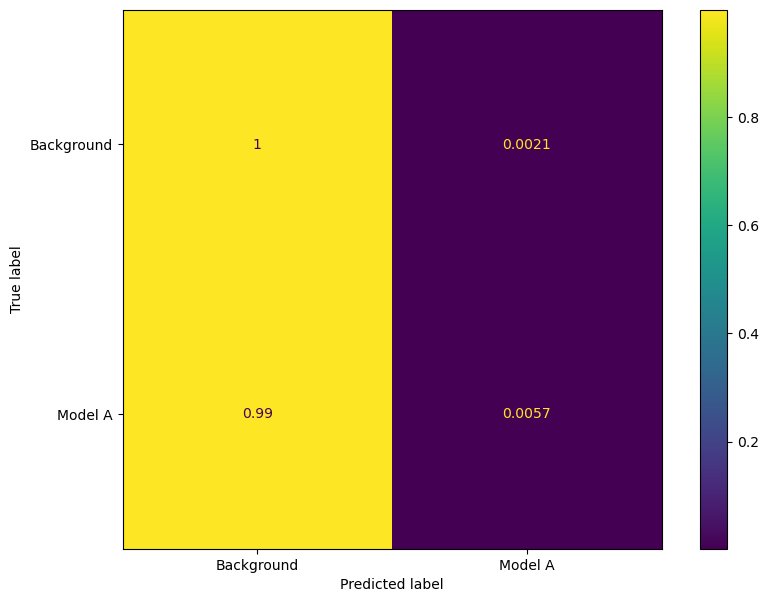

30197/30197 [==============================] - 17s 560us/step
Model B
Precision: 0.664
Recall: 0.723
F1: 0.610
Accuracy: 0.723


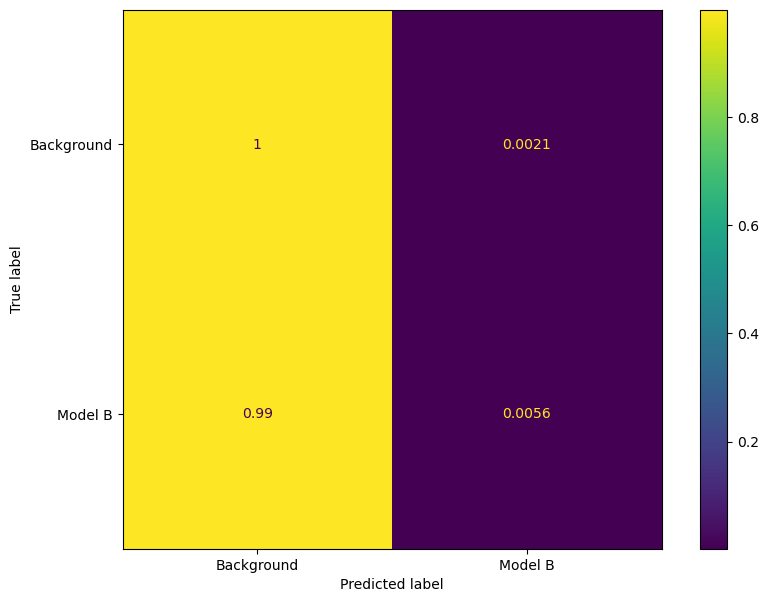

28817/28817 [==============================] - 16s 558us/step
Model C
Precision: 0.664
Recall: 0.725
F1: 0.612
Accuracy: 0.725


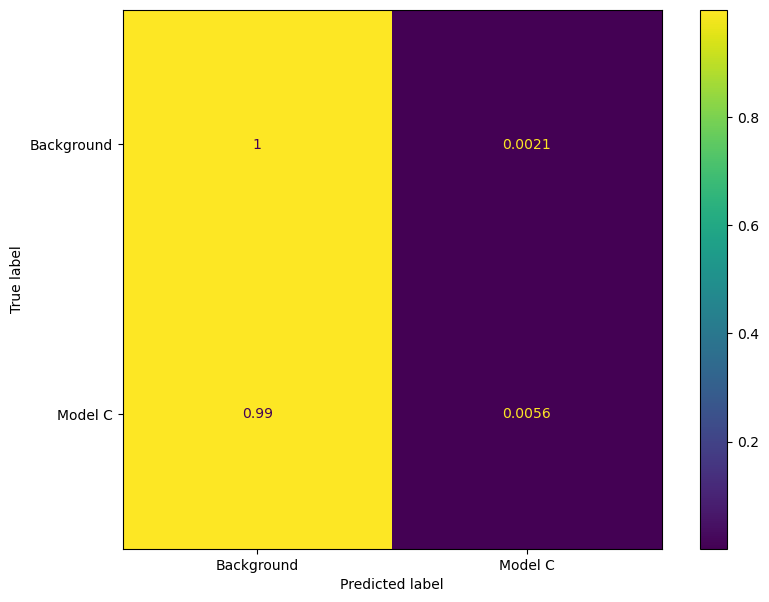

25941/25941 [==============================] - 14s 554us/step
Model D
Precision: 0.676
Recall: 0.737
F1: 0.628
Accuracy: 0.737


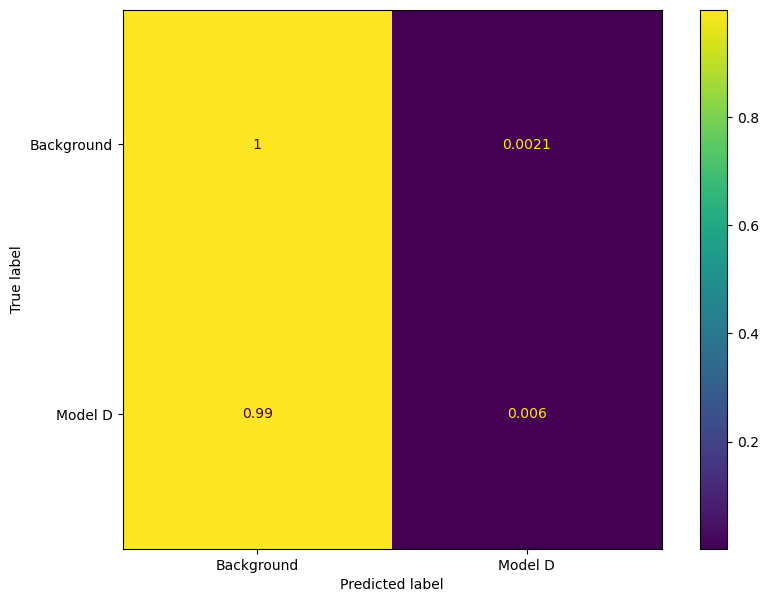

In [46]:
models = ['A', 'B', 'C', 'D']
for model in models:
    make_cm(model)

In [74]:
df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
for model in models:
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')], ignore_index=True)
df_bkgsig = df_test.copy()
df_bkgsig.labels = df_test.labels.replace([2, 3, 4], 1)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(df_bkgsig.iloc[:, :-2], df_bkgsig.iloc[:, -2], test_size=0.2, random_state=42)
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_train_control = y_train[x_train_control.index]

x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

In [50]:
labs = {0:'Background', 1:'Signal'}

In [51]:
_, _, z = encoder.predict(x_test_control)
y_preds = decoder.predict(z)

6364/6364 [==============================] - 3s 506us/step


In [52]:
y_test = x_test_control.flatten()
y_test = np.around(y_test)

In [53]:
y_pred = y_preds.flatten()
y_pred = np.around(y_pred)

In [54]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.514
Recall: 0.006
F1: 0.012
Accuracy: 0.738


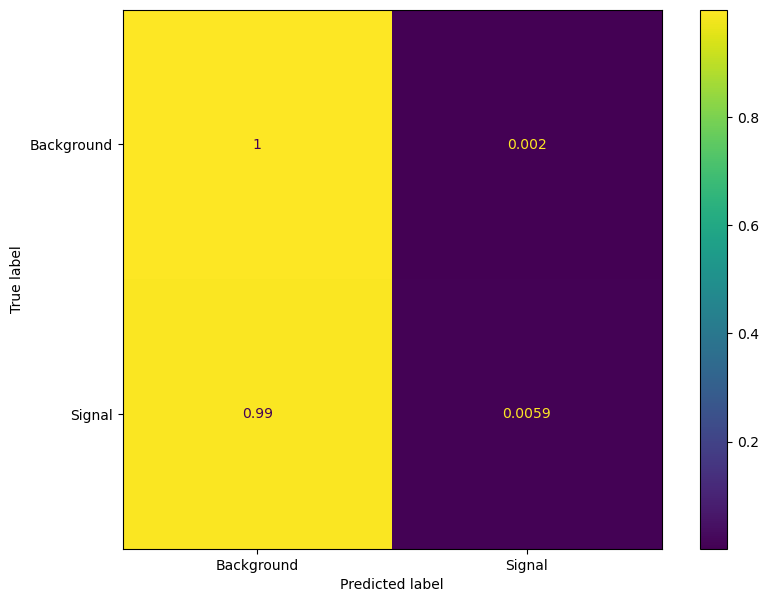

In [55]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# ROC Curves

In [56]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')

In [57]:
df = df.sample(frac=1., random_state=42)
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
437478,1367.286865,0.514140,36.874817,-0.567162,-0.051784,26,32,-41.350748,-42.145892,0.289053,0
633446,1349.734497,0.461035,15.258850,-1.076562,-1.548793,45,63,-22.185350,-10.916061,0.249620,0
93057,2834.843506,3.014004,61.552490,-1.235404,1.805601,16,31,-58.638833,-54.183687,0.215897,0
582194,1380.331421,0.739724,52.043762,0.897393,0.134441,25,62,-42.472107,-12.314901,0.138052,0
649851,1528.705688,1.784996,92.635620,0.002620,1.822954,47,40,-21.761047,-36.131667,0.401371,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,1285.024292,0.913437,8.821899,-0.431818,0.493761,27,35,-39.554488,-38.044520,0.359813,0
365838,1359.271973,0.337475,92.623596,0.944897,0.632759,41,55,-26.275523,-19.041290,0.593621,0
131932,2054.116943,2.140792,145.848389,-1.060299,1.120960,65,38,-7.119301,-43.129277,0.308462,0
671155,1248.218506,1.125891,124.323944,0.073235,1.242163,18,32,-48.180650,-40.531574,0.394253,0


In [58]:
features = df.iloc[:, :-2]
labels = df.labels

In [59]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [60]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_train_control = y_train[x_train_control.index]

In [61]:
scaler = MinMaxScaler()
x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

In [62]:
features = np.array(features)

In [63]:
features = MinMaxScaler().fit_transform(features)

In [64]:
_, _, z = encoder.predict(x_test_control)
y_preds = decoder.predict(z)

6365/6365 [==============================] - 3s 510us/step


In [65]:
y_tst = np.around(x_test_control.flatten())
y_pred = np.around(y_preds.flatten())

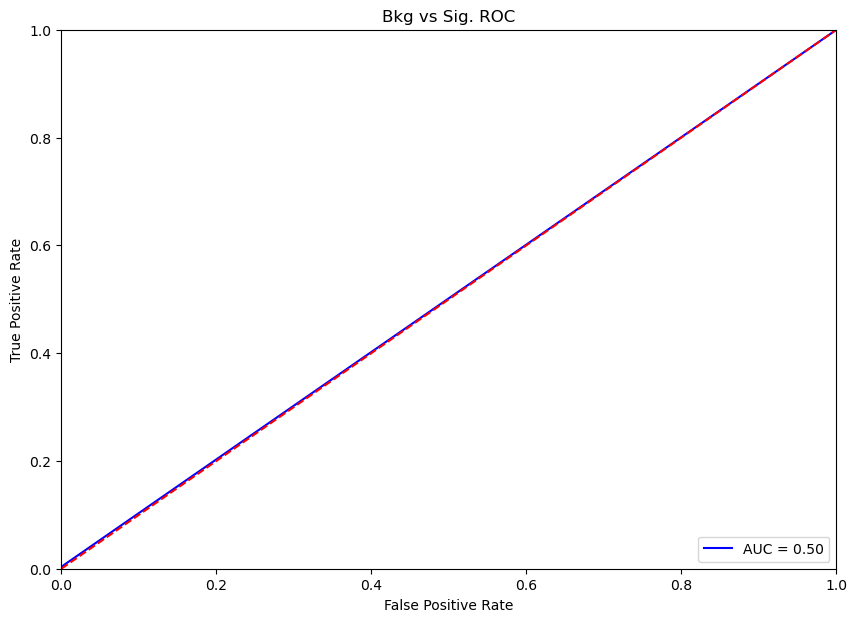

In [68]:
fpr, tpr, threshold = roc_curve(y_tst, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
opt_thresh_bin = threshold[np.argmax(tpr-fpr)]
opt_thresh_bin

1.0

In [71]:
df_1vr = df.copy()
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    #features = MinMaxScaler().fit_transform(features)
    #probs = nbc_bin.predict_proba(features)
    #preds = probs[:, 1]
    _, _, z = encoder.predict(x_test_control)
    preds = decoder.predict(z)
    fpr, tpr, thresh = roc_curve(np.around(x_test_control.flatten()), np.around(preds.flatten()))
    roc_auc = auc(fpr, tpr)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fpr
    fpr_tpr_auc[i]['tpr'] = tpr
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
6365/6365 [==============================] - 3s 494us/step
[1, 3, 4]
6365/6365 [==============================] - 3s 509us/step
[1, 2, 4]
6365/6365 [==============================] - 3s 492us/step
[1, 2, 3]
6365/6365 [==============================] - 3s 484us/step


Model A optimum classification threshold: 1.000
Model B optimum classification threshold: 1.000
Model C optimum classification threshold: 1.000
Model D optimum classification threshold: 1.000


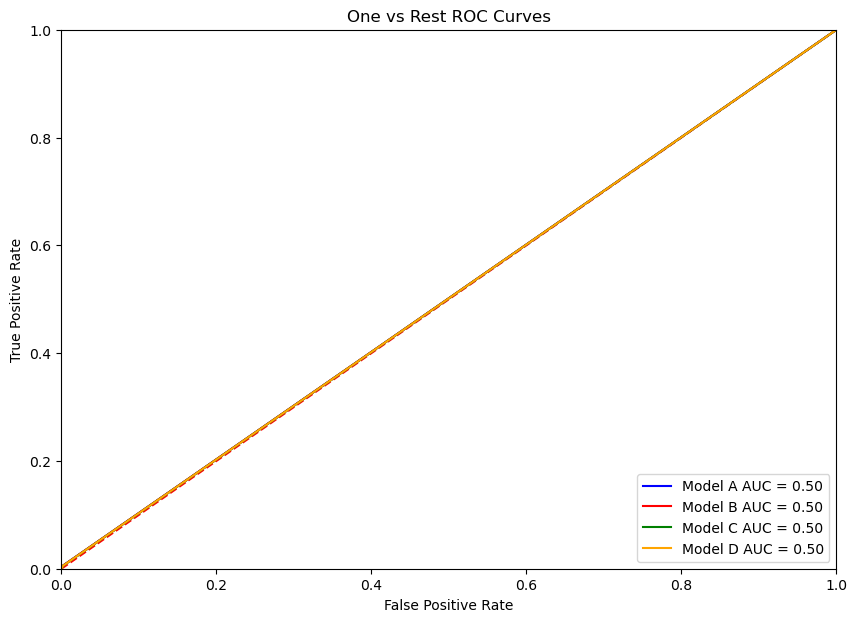

In [72]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()

# testing on control, train on pre

In [12]:
#history_val = vae.fit(x_val, epochs = 5, batch_size = 128)
history = vae.fit(x_train, epochs = 5, batch_size = 128)

Epoch 1/5
6462/6462 [==============================] - 7s 895us/step - loss: 0.0265 - reconstruction_loss: 0.0261 - kl_loss: 3.8372e-04
Epoch 2/5
6462/6462 [==============================] - 6s 884us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 5.6825e-07
Epoch 3/5
6462/6462 [==============================] - 6s 872us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 4.0599e-07
Epoch 4/5
6462/6462 [==============================] - 6s 872us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 3.6269e-07
Epoch 5/5
6462/6462 [==============================] - 6s 866us/step - loss: 0.0251 - reconstruction_loss: 0.0251 - kl_loss: 3.0937e-07


# Confusion Matrices

# Working on cell below to get the testing done on control data

In [18]:
def make_cm(model):
    df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')], ignore_index=True) 
    x_train, x_test, y_train, y_test = train_test_split(df_test.iloc[:, :-2], df_test.iloc[:, -2], test_size=0.2, random_state=42)
    x_test_control = x_test[(x_test.lead_ntrk < 0)]
    x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
    x_train_control = x_train[(x_train.lead_ntrk < 0)]
    x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

    y_test_control = y_test[x_test_control.index]
    y_train_control = y_train[x_train_control.index]
    
    x_train = scaler.fit_transform(x_train.iloc[:, :7])
    x_test = scaler.fit_transform(x_test_control.iloc[:, :7])
    _, _, z = encoder.predict(x_train)
    y_preds = decoder.predict(z)
    y_test = x_train.flatten()
    y_test = np.around(y_test)
    y_pred = y_preds.flatten()
    y_pred = np.around(y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Model %s\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(model, precision, recall, f1, accuracy))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tick_labs = ['Background', 'Model %s'%(model)]
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
    fig, ax = plt.subplots(figsize = (10, 7))
    cm_display.plot(ax=ax)
    plt.show()

32306/32306 [==============================] - 16s 505us/step
Model A
Precision: 0.795
Recall: 0.837
F1: 0.794
Accuracy: 0.837


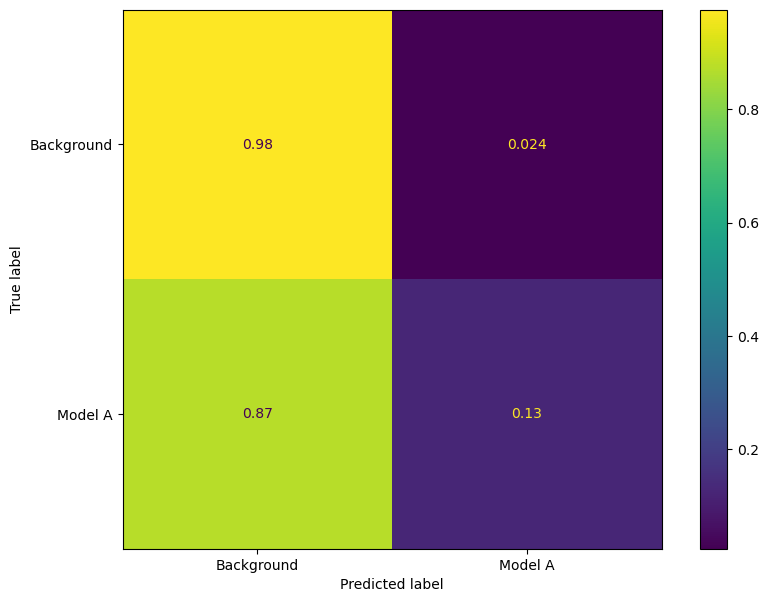

32306/32306 [==============================] - 17s 515us/step
Model B
Precision: 0.795
Recall: 0.837
F1: 0.794
Accuracy: 0.837


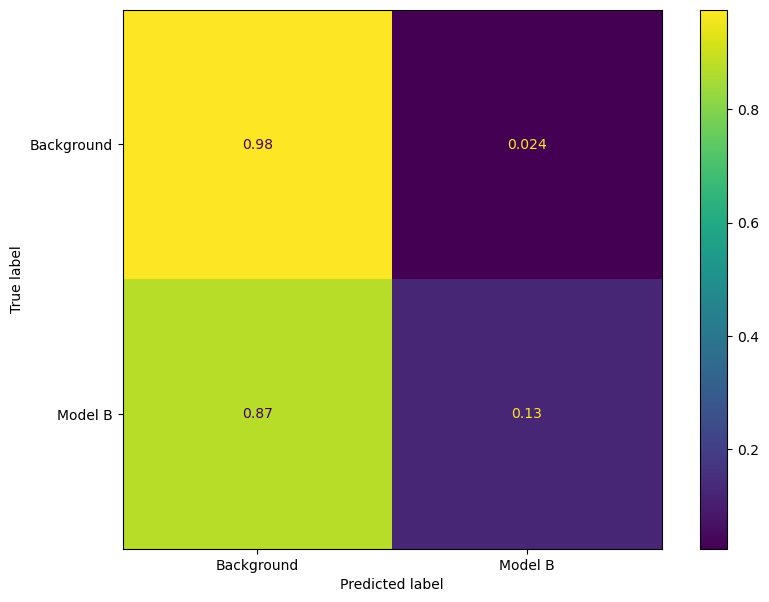

32306/32306 [==============================] - 16s 504us/step
Model C
Precision: 0.796
Recall: 0.838
F1: 0.796
Accuracy: 0.838


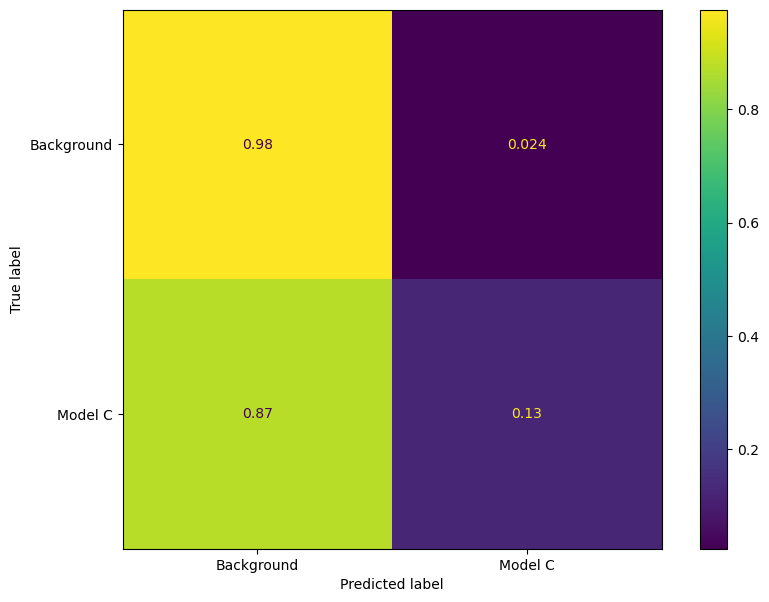

32306/32306 [==============================] - 16s 509us/step
Model D
Precision: 0.796
Recall: 0.838
F1: 0.795
Accuracy: 0.838


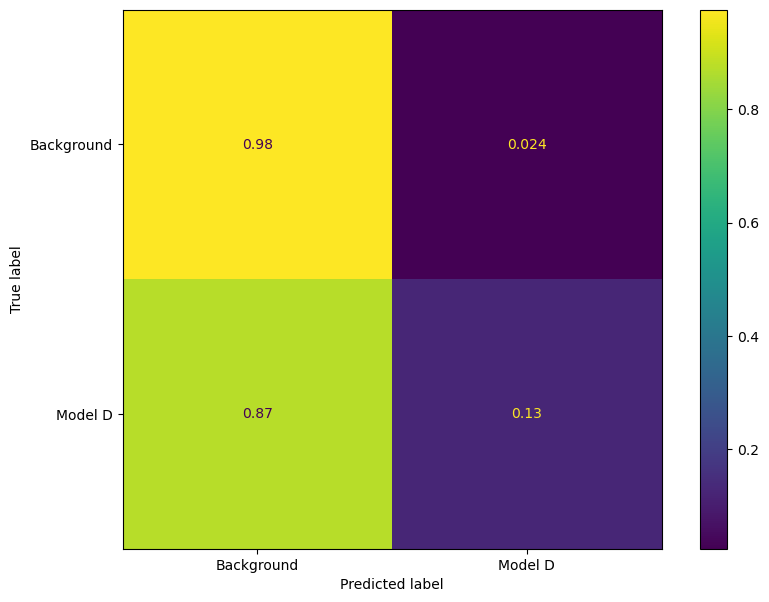

In [19]:
models = ['A', 'B', 'C', 'D']
for model in models:
    make_cm(model)

In [20]:
df_test = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
for model in models:
    df_test = pd.concat([df_test, pd.read_csv('df_model%s_red.csv'%(model)).drop(columns = 'Unnamed: 0')], ignore_index=True)
df_bkgsig = df_test.copy()
df_bkgsig.labels = df_test.labels.replace([2, 3, 4], 1)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_bkgsig.iloc[:, :-2], df_bkgsig.iloc[:, -2], test_size=0.2, random_state=42)
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_train_control = y_train[x_train_control.index]

x_train = scaler.fit_transform(x_train.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

In [22]:
labs = {0:'Background', 1:'Signal'}

In [23]:
_, _, z = encoder.predict(x_test_control)
y_preds = decoder.predict(z)

8922/8922 [==============================] - 5s 561us/step


In [24]:
y_test = x_test_control.flatten()
y_test = np.around(y_test)

In [25]:
y_pred = y_preds.flatten()
y_pred = np.around(y_pred)

In [26]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.501
Recall: 0.070
F1: 0.123
Accuracy: 0.704


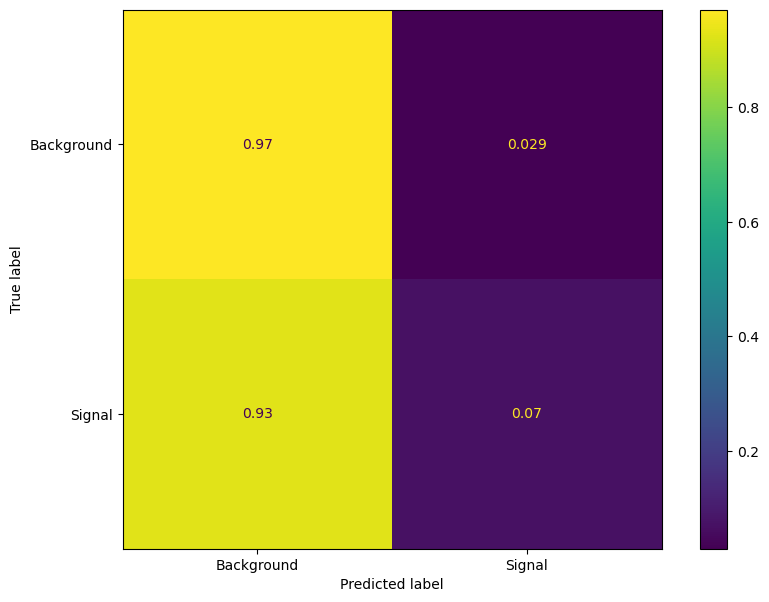

In [27]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# ROC Curves

In [28]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')

In [29]:
df = df.sample(frac=1., random_state=42)
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
437478,1367.286865,0.514140,36.874817,-0.567162,-0.051784,26,32,-41.350748,-42.145892,0.289053,0
633446,1349.734497,0.461035,15.258850,-1.076562,-1.548793,45,63,-22.185350,-10.916061,0.249620,0
93057,2834.843506,3.014004,61.552490,-1.235404,1.805601,16,31,-58.638833,-54.183687,0.215897,0
582194,1380.331421,0.739724,52.043762,0.897393,0.134441,25,62,-42.472107,-12.314901,0.138052,0
649851,1528.705688,1.784996,92.635620,0.002620,1.822954,47,40,-21.761047,-36.131667,0.401371,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,1285.024292,0.913437,8.821899,-0.431818,0.493761,27,35,-39.554488,-38.044520,0.359813,0
365838,1359.271973,0.337475,92.623596,0.944897,0.632759,41,55,-26.275523,-19.041290,0.593621,0
131932,2054.116943,2.140792,145.848389,-1.060299,1.120960,65,38,-7.119301,-43.129277,0.308462,0
671155,1248.218506,1.125891,124.323944,0.073235,1.242163,18,32,-48.180650,-40.531574,0.394253,0


In [30]:
features = df.iloc[:, :-2]
labels = df.labels

In [31]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [32]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_train_control = y_train[x_train_control.index]

In [33]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

In [34]:
features = np.array(features)

In [35]:
features = MinMaxScaler().fit_transform(features)

In [36]:
_, _, z = encoder.predict(x_test_control)
y_preds = decoder.predict(z)

6365/6365 [==============================] - 3s 508us/step


In [37]:
y_tst = np.around(x_test_control.flatten())
y_pred = np.around(y_preds.flatten())

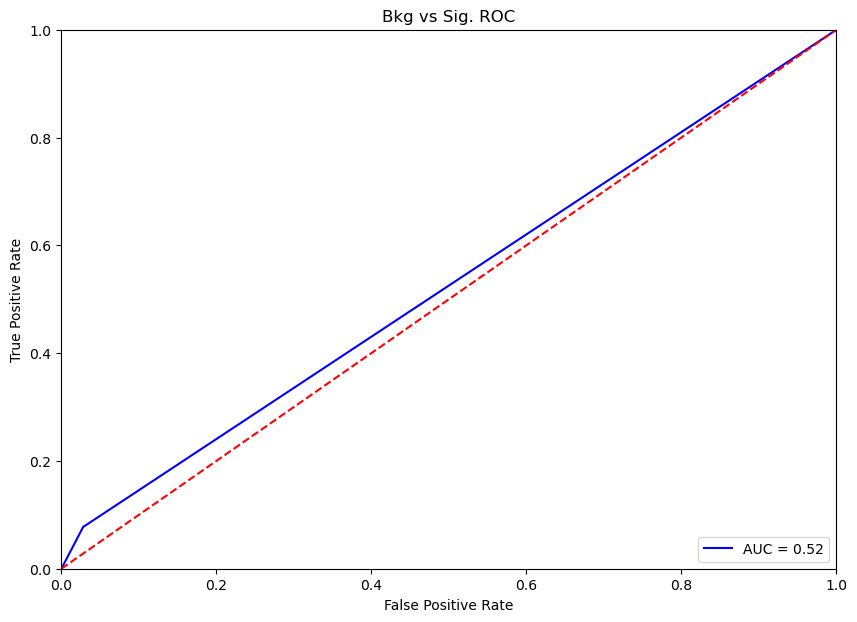

In [38]:
fpr, tpr, threshold = roc_curve(y_tst, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
df_1vr = df.copy()
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    #features = MinMaxScaler().fit_transform(features)
    #probs = nbc_bin.predict_proba(features)
    #preds = probs[:, 1]
    _, _, z = encoder.predict(x_test_control)
    preds = decoder.predict(z)
    fpr, tpr, thresh = roc_curve(np.around(x_test_control.flatten()), np.around(preds.flatten()))
    roc_auc = auc(fpr, tpr)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fpr
    fpr_tpr_auc[i]['tpr'] = tpr
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
6365/6365 [==============================] - 3s 544us/step
[1, 3, 4]
6365/6365 [==============================] - 3s 521us/step
[1, 2, 4]
6365/6365 [==============================] - 3s 525us/step
[1, 2, 3]
6365/6365 [==============================] - 3s 525us/step


Model A optimum classification threshold: 1.000
Model B optimum classification threshold: 1.000
Model C optimum classification threshold: 1.000
Model D optimum classification threshold: 1.000


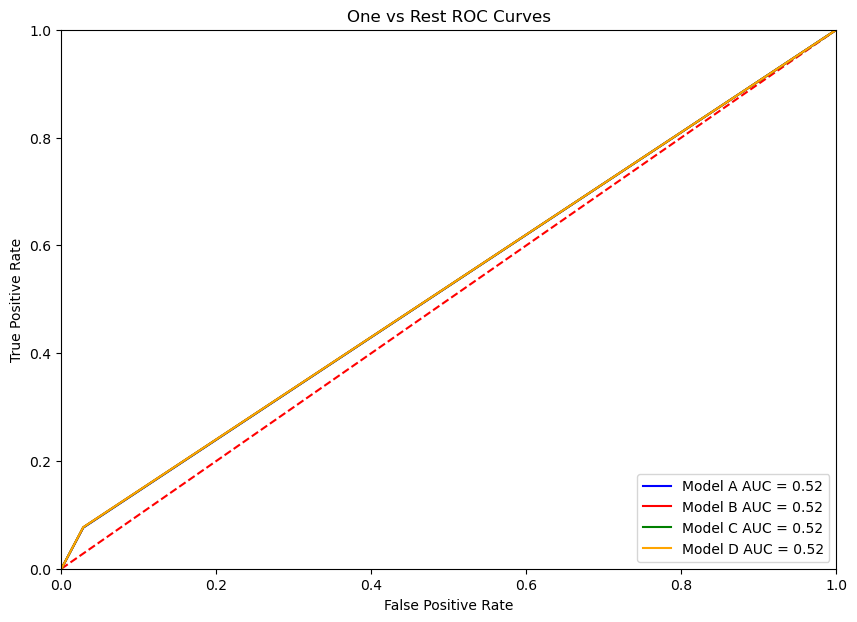

In [40]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()